In [1]:
# !pip install osmnx folium matplotlib mapclassify

In [2]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import math as m
import numpy as np
import traceback
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import folium
import shapely
import warnings
import csv
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Uncomment in case of not having osmnx tool
#df = pd.read_csv('https://data.sfgov.org/api/views/8vzz-qzz9/rows.csv?accessType=DOWNLOAD') # read in the data and pickle 
#df.to_pickle('sf_data.pkl')

In [4]:
# reading cleaned data in pickle
df = pd.read_pickle('sf_data.pkl')

### Making GeoDataFrame out of data and then casting it to san-franciscan coordinate system.

<AxesSubplot:>

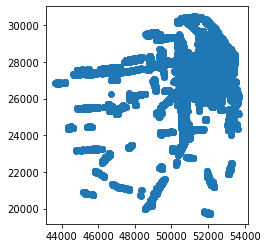

In [5]:
df.dtypes
pmeters = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))
pmeters = pmeters.set_crs(epsg=4326)#EPSG:4326  - classical geographical latitude and longitude
pmeters = pmeters.to_crs(7131)#project to coordinate system appropriate for San Francisco (found on: https://epsg.io/7131)
pmeters.dtypes
pmeters.plot()

In [6]:
# Checking first couple of records
df.head()

,OBJECTID,PARKING_SPACE_ID,POST_ID,MS_PAY_STATION_ID,MS_SPACE_NUM,SENSOR_FLAG,ON_OFFSTREET_TYPE,OSP_ID,JURISDICTION,PM_DISTRICT_ID,...,NFC_KEY,COLLECTION_ROUTE_DESC,COLLECTION_SUBROUTE_DESC,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,geometry
0,5228201,101400,500-08020,-,0,N,ON,0,SFMTA,12,...,6325,_missing_,_missing_,POINT (-122.408394 37.79584),104,104,6,3,6,POINT (-122.40841 37.79585)
1,5228280,102036,419-13290,-,0,N,ON,0,SFMTA,15,...,9EPC,Franklin St: Unit - 900,Franklin 1200-1500,POINT (-122.423454 37.7872),100,100,4,6,39,POINT (-122.42347 37.78721)
2,5229090,109966,671-01050,671-01001,5,Y,ON,0,SFMTA,2,...,8JGP,_missing_,_missing_,POINT (-122.39461 37.780937),31,31,1,10,8,POINT (-122.39462 37.78094)
3,5229183,104916,606-15400,-,0,N,ON,0,SFMTA,15,...,6X57,_missing_,_missing_,POINT (-122.42171 37.789528),105,105,4,3,21,POINT (-122.42172 37.78953)
4,5229690,107918,418-06100,-,0,E,ON,0,SFMTA,2,...,3NBT,_missing_,_missing_,POINT (-122.397156 37.785294),32,32,1,10,8,POINT (-122.39717 37.78530)


In [7]:
# We decided

### Function for splitting the dataset.
We have decided that since raletion parking meter - waynode is strictly local, the dataset may be simply divided spatially into parts and then simple matching algorithm run effectively on these individual parts (tiles).

In [8]:
# constraints which determine the borders of map
longitude_min, longitude_max, lattitude_min, lattitude_max  = df['LONGITUDE'].min(),  df['LONGITUDE'].max(), df['LATITUDE'].min(), df['LATITUDE'].max()
def tilenum(lat, lon, root_num_tiles=10):
    return m.floor((lat - lattitude_min) / (lattitude_max-lattitude_min) * root_num_tiles) + m.floor((lon - longitude_min) / (longitude_max-longitude_min) * root_num_tiles) * root_num_tiles


In [9]:
def get_tiles(df, root_num_tiles):
    df['TILE'] = df.apply(lambda x: tilenum(x['LATITUDE'], x['LONGITUDE']), axis=1)
    parts =  df.groupby('TILE')
    return parts


### Function for downloading graph of waynodes via osmnx.
It uses graph_from_bbox and boundaries are in WGS84.

In [10]:
def get_waynodes_in_area_of(df):
    longitude_min, longitude_max, lattitude_min, lattitude_max  = df['LONGITUDE'].min(),  df['LONGITUDE'].max(), df['LATITUDE'].min(), df['LATITUDE'].max()
    print("BOUNDS:",lattitude_max,lattitude_min,longitude_max,longitude_min)
    G = ox.graph_from_bbox(lattitude_max,lattitude_min,longitude_max,longitude_min, network_type='drive', simplify=False, truncate_by_edge=True) # get the graph
    print("number_of_nodes:", G.number_of_nodes())
    print("number_of_edges:", G.number_of_edges())
    return G


### Interactive map.
To conveniently view partial results, we have written this contraption. It shows an interactive map. Roads are red lines. Parking meters are green pins, clicking on which shows all columns for given device. Blue lines connect parking meter with a centroid of nearest segment (line between two waynodes). The map, when zoomed past certain point goes blank-gray. It is an effect of forcibly increasing max_zoom for folium map (to see be able to see those lines closely), it is a feature of library and it can't be circumvented (different image tiles would be needed). This code has no purpose apart from visualization in interactive use and is not essential (should it stop working due to some library problems).

In [11]:
def show_map_of_assignments(ret, orig_nodes, ways):
  rv = ret
  rv['geometry'] = rv['visual']
  for id, row in rv.iterrows():
    if row["PARKING_SPACE_ID"] == 115402:
      print(row["apart"])
      print("NODE 115402")
  rv.drop(columns=['visual'], inplace=True)
  rv = rv.set_crs(epsg=7131)
  rv = rv.to_crs(4326)
  map = folium.Map([37.75,-122.39], zoom_start=12, max_zoom=30)
 
  folium.Choropleth(
    rv,#[rv.geometry.length>0.001],
    line_weight=3,
    line_color='blue'
  ).add_to(map)
  
  
  #above: https://anitagraser.com/2019/10/31/interactive-plots-for-geopandas-geodataframe-of-linestrings/
  
  #below: https://geopandas.org/en/stable/gallery/plotting_with_folium.html
  df_deg = orig_nodes.set_crs(epsg=7131)
  df_deg = df_deg.to_crs(4326)
  geo_df_list = [([ row[1]['geometry'].xy[1][0], row[1]['geometry'].xy[0][0]], row[1].to_json(default_handler=str).replace(",","\n")) for row in df_deg.iterrows() ]
  i = 0
  for t in geo_df_list:
    coordinates = t[0]
    desc = t[1]
    # Place the markers with the popup labels and data
    map.add_child(folium.Marker(location = coordinates,
                            popup = desc,
                            icon = folium.Icon(color = "green") 
                            ))
    i = i + 1
  #3 - all ways
  if ways is not None:
    folium.Choropleth(
      ways,#[rv.geometry.length>0.001],
      line_weight=3,
      line_color='red'
    ).add_to(map)

  display(map)


## Main algorithm
The crucial function is associate_waynodes. It performs association of parking meters to waynodes, using comparator-like function compare_parking_meter_with_waysegment and while getting appropriate osmnx data. It is oblivius to dataset division, which is performed by following function associate_while_splitting_dataset. Running associate_waynodes on whole datasets would be possible, but it would probably takes ages.

### Comparator-like function.
It computes joined row along with metric signifying auality of a match.

In [12]:
def compare_parking_meter_with_waysegment(pmeter, way, nodes):#nodes of parking meters, representation of way segments, table of all individual nodes of streets
  node1id = way.name[0]
  node2id = way.name[1]
  node1 = nodes.loc[node1id]
  node2 = nodes.loc[node2id]
  distance = pmeter['geometry'].distance(way['geometry'])
  if distance < 30:#[m]
    pmeter['street_osmid'], pmeter['node1_osmid'], pmeter['node2_osmid'] = way.osmid, node1id, node2id
    
    center = way['geometry'].centroid
    pmeter['visual'] = LineString([center, pmeter['geometry']])
    pmeter['apart'] = distance
    metric = distance # determines how good an association is
    return (metric, pmeter, center)

### Main matching function.
 The parking meters are passed to it, it gets appropriate waynodes and performs a match. The algorithm is simple, crude even, but the use of double for is intentional. It allows for building a list of candidates, along with metric, provided by comparator-like function. Then the best match for each parking meter is chosen. Algorithm is general, with cmparing function swapped, it could be used for any kind of matching geospatial points to waynodes of OpenStreetMap.
 The output is appended to specified csv file (if it is empty, column names are written, otherwise not). It maens that, if association is done by parts and process is stopped, parial results will be saved.

In [13]:

from IPython.display import display
import sys
#main function of the algorithm
def associate_waynodes(df, earlystop=sys.maxsize, showmap=False, csv_path=''):
  ret = pd.DataFrame()
  try:
    G = get_waynodes_in_area_of(df)
    nodes_edges = ox.utils_graph.graph_to_gdfs(G,nodes=True, edges=True)#, node_geometry=True, fill_edge_geometry=True) #https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_to_gdfs
    nodes = nodes_edges[0]
    ways = nodes_edges[1]
    ways.rename(columns={"name": "street_name"}, inplace=True)#To avoid confusion with df.name (printed as Name)
    ways = ways.to_crs(7131)
    nodes = nodes.to_crs(7131)
  except:
    print(traceback.format_exc())
    return ret

  i=-1
  for pointnum, point in df.iterrows():#iterate over points from first dataset
    i +=1
    if i > earlystop:
      break#crude mechanism for early stopping not to wait half a minute every single time...
    candidates = list()#accumulate candidates to be associated with given point
    for waynum, way in ways.iterrows():#iterate over all nodes
        r = compare_parking_meter_with_waysegment(point, way, nodes)#comparative function
        if r is not None:
          candidates.append(r)
    if len(candidates) > 0:
      candidates.sort(key=lambda x: x[0])#sort by metric provided by the comparator, to return the highest rated possibility
      best_candidate = candidates[0]
      for c in candidates:
        if c[0] <= best_candidate[0]:
          best_candidate = c
       



      best_candidate[1]['apart'] = best_candidate[0]
      best_candidate[1]['visual'] = LineString([best_candidate[2], best_candidate[1]['geometry']])
      #HERE MAY BE LOGIC FOR CHOOSING AMONG CANDIDATE SEGMENTS
      ret = ret.append(best_candidate[1], ignore_index=True)#zeroth element of sorted list of tuples, which have rows on first position, contains now best match
  ret = gpd.GeoDataFrame(ret)
  if showmap:
    show_map_of_assignments(ret, df, ways)
    
  #Saving (appending) to output file.
  with open(csv_path, "r") as f:
    f.seek(0,2)#go to the end of file
    f_is_empty = (f.tell() == 0)#read position in file and determine if file is empty
  ret.to_csv(csv_path,mode='a', header=f_is_empty)#append to file, if file is empty, write columns
  return ret


### Testing algorithm for one tile.
As processing whole dataset takes a while (for me, more than two hours), we have written a simple helper function, which runs a process for only one tile, which takes half a minute, or seconds even, if earlystop parameter of associate_waynodes is utilised, which greatlyhelpedin developement of the script. It also shows the map. We have not attempted to show the map for a whole dataset, since 30k pins would certainly freeze javascript underneath the interactive map.

In [14]:
def associate_for_one_tile(df, square_root_of_num_parts, tilenum):
  with open('one_tile_df.csv', 'w+'):
    pass  
  parts = get_tiles(df, square_root_of_num_parts)
  #print(parts)
  res = associate_waynodes(parts.get_group(tilenum), showmap=True, csv_path='one_tile_df.csv')
  
  return res

In [15]:
#res = associate_for_one_tile(pmeters, 10, 6)#uncomment, if You wish to see the map. (Note: Not all tilenums exist, since there are tiles entirely filled with the sea.)

### Wrapper function dispatching the main one on parts of the dataset
It divides dataset. Parts are fed into associate_waynodes function and it can be observed as result file grows with time on disk. Some statistics are also printed. 

In [16]:
def associate_while_splitting_dataset(df, square_root_of_num_parts):
  #result = pd.DataFrame()
  with open('all_tiles_df.csv', 'w+'):
    pass
  sum_pts = 0
  sum_assoc = 0
  parts = get_tiles(df, square_root_of_num_parts)
  for i, part in parts:
    print("PART:",i,", size:",part.shape[0])
    partresult = associate_waynodes(part, csv_path='all_tiles_df.csv')
    print("associated:", partresult.shape[0])
    sum_pts += part.shape[0]
    sum_assoc += partresult.shape[0]
    print("after", i, ":", sum_assoc, "/", sum_pts, " (", 100*sum_assoc/sum_pts,"%)")

In [18]:
associate_while_splitting_dataset(pmeters, 10)